In [2]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [3]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45101 instead
  warnings.warn(


In [4]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None # '~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'vprofile'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('ocean_basins/Arctic_Basin.shp')
box_regions.append('ocean_basins/Eurasian_Basin.shp')
box_regions.append('mpas_region/Canada_Basin.shp')
box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
box_regions.append('mpas_region/Greenland_Sea.shp')
box_regions.append('mpas_region/Irminger_Sea.shp')
box_regions.append('mpas_region/Norwegian_Sea.shp')
box_regions.append('mpas_region/Labrador_Sea.shp')
# box_regions.append('mpas_region/North_Pacific_Ocean.shp')
# box_regions.append('mpas_region/South_Pacific_Ocean.shp')
box_regions.append('mpas_region/Southern_Ocean.shp')
box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
ncol      = 3 
do_rescale= None
do_rescale= 'log10'
which_dpi = 300

In [5]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])

    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)

#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
        
#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))   

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#________________________________________________________________________________________________________
# setup colors for different lines
#which_cmap = 'gist_ncar'
# which_cmap = 'nipy_spectral'
#colors = plt.get_cmap(which_cmap)(np.linspace(0.1,0.9,len(input_paths)))
#categcmap = matplotlib.colors.ListedColormap(colors)

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > load  *.pckl file: tripyview_fesom2_dart_test_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > id              = dart_test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Eurasian_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Canada_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/North_Atlantic_Ocean.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Gr

In [6]:
#________________________________________________________________________________________________________
# allocate lists
lw_min,lw_max = 0.5, 1.5
list_index  = list()
list_labels = list()
list_lcolor = list()
list_lwidth = list()
list_lstyle = list()

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
clim_vname = vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim and  (ref_path is None): 
    ts = clock.time()
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, do_load=False, do_persist=True)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))

    ts = clock.time()
    list_index.append(tpv.load_index_fesom2(mesh, clim, box, do_harithm='wmean'))
    print(' --> elasped time to comp. vert. clim profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
    list_labels.append(which_clim.upper())
    list_lcolor.append('k')
    list_lwidth.append(lw_max)
    list_lstyle.append([])
else: raise ValueError('climatology not supported for choosen vname')   
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    data       = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript , 
                                      do_info=False, do_zarithm=None, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________    
    # create reference vert. profile if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        ts = clock.time()
        data_ref = tpv.load_index_fesom2(mesh, data_ref, box) 
        print(' --> elasped time to comp. vert. ref profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
        # collect the lines in a list: --> zero reference line
        ref_index  = list()    
        for ii, idx in enumerate(data_ref):
            ref_index.append(idx.copy())
            idx_vname = list(idx.keys())
            ref_index[ii][vname].data = np.zeros((len(ref_index[ii][vname].data), ))
        list_index.append(ref_index)
        list_labels.append(descript)
        list_lcolor.append('k')
        list_lwidth.append(lw_max)
        list_lstyle.append([])   
        continue
        
    #__________________________________________________________________________________________________  
    # create vert. profile --> collect the lines in a list
    ts = clock.time()
    data_index = tpv.load_index_fesom2(mesh, data, box)
    print(' --> elasped time to comp. vert. profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    if  (ref_path != None and ref_path != 'None'): 
        list_index.append(tpv.do_indexanomaly(data_index, data_ref))
        list_labels.append(data_index[0][vname].attrs['descript']+'-'+data_ref[0][vname].attrs['descript'])
    else:
        list_index.append(data_index)
        list_labels.append(data[vname].attrs['descript'])
    list_lcolor.append([])
    list_lwidth.append(lw_max)
    list_lstyle.append([])    
if  (ref_path != None and ref_path != 'None'): del(data_ref)

 --> elasped time to load clim: 0.10 min.
 --> clim uses 1.66 Gb:
 --> elasped time to comp. vert. clim profile.: 0.18 min.
0 /albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ TKE
 --> elasped time to load data: 0.04 min.
 --> data uses 1.66 Gb:
 --> elasped time to comp. vert. profile.: 0.43 min.


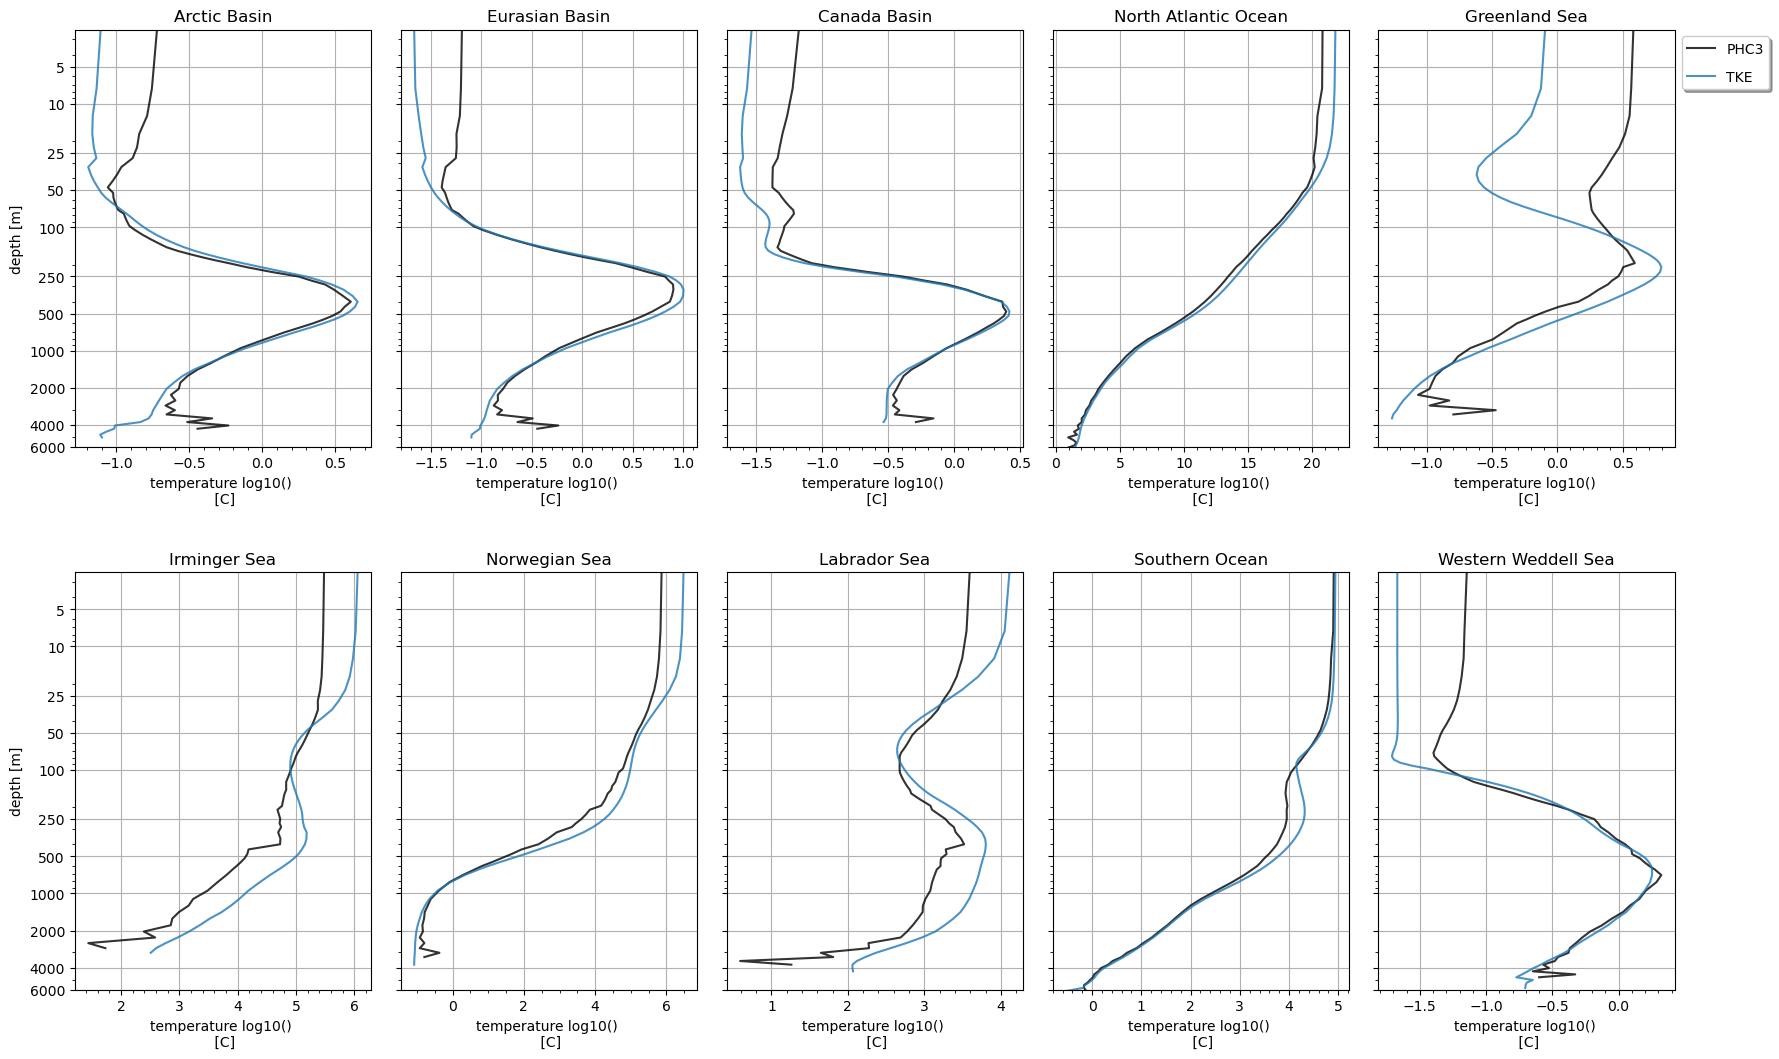

In [7]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = list_index[-1][0][sname].attrs['str_lsave']
if spath is not None: spath  = '{}/{}_{}_{}.png'.format(spath, which_mode, sname, slabel) 
nrow   = 2 
if save_fname is not None: spath = save_fname
fig, ax = tpv.plot_index_z(list_index,
                           list_labels,
                           box, figsize=[20,12], n_rc=[nrow,np.ceil(len(box)/nrow).astype(int)],
                           linecolor_list= list_lcolor,
                           linestyle_list= list_lstyle,
                           linewidth     = list_lwidth,
                           do_save       = spath,
                           do_rescale    = do_rescale,    
                          )  